<a href="https://colab.research.google.com/github/sakib7/ml-project-versioning/blob/main/lstm_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
# Utilities
import re
import pickle
import numpy as np
import pandas as pd

# Plot libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [66]:
url = "https://raw.githubusercontent.com/sakib7/IT00CD79-3005-Machine-Learning/main/Sentiment140.tenPercent.sample.tweets.tsv"
dataset = pd.read_csv(url, delimiter="\t")
dataset['sentiment'] = dataset['sentiment_label'].replace(4,1)
dataset['text'] = dataset['tweet_text']
dataset = dataset.drop(columns=['tweet_text', 'sentiment_label'])
# print(dataset.head(10))
dataset

,sentiment,text
0,1,"@elephantbird Hey dear, Happy Friday to You A..."
1,1,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...
...,...,...
159995,0,STILL @ panera...studying for &quot;mock&quot;...
159996,0,Insomnia is out of control tonight--haven't sl...
159997,1,@Covergirl08 I take pride in what I do
159998,1,heading to work on the 6


In [67]:
# Reading contractions.csv and storing it as a dict.
contractions = pd.read_csv('https://raw.githubusercontent.com/sakib7/IT00CD79-3005-Machine-Learning/main/contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'', tweet)

    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '', tweet)
    tweet = re.sub(smileemoji, '', tweet)
    tweet = re.sub(sademoji, '', tweet)
    tweet = re.sub(neutralemoji, '', tweet)
    tweet = re.sub(lolemoji, '', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    # tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [68]:
%%time
dataset['processed_text'] = dataset.text.apply(preprocess_apply)

CPU times: user 9.11 s, sys: 43.5 ms, total: 9.15 s
Wall time: 9.26 s


In [69]:
count=0
for row in dataset.itertuples():
    print("Text:", row[2])
    print("Processed:", row[3])
    count+=1
    if count>10:
        break

Text: @elephantbird Hey dear, Happy Friday to You  Already had your rice's bowl for lunch ?
Processed:  hey dear  happy friday to you  already had your riceis bowl for lunch  
Text: Ughhh layin downnnn    Waiting for zeina to cook breakfast
Processed: ughh layin downn  waiting for zeina to cook breakfast
Text: @greeniebach I reckon he'll play, even if he's not 100%...but i know nothing!! ;) It won't be the same without him. 
Processed:  i reckon he will play  even if he is not 100   but i know nothing    it will not be the same without him  
Text: @vaLewee I know!  Saw it on the news!
Processed:  i know   saw it on the news 
Text: very sad that http://www.fabchannel.com/ has closed down. One of the few web services that I've used for over 5 years 
Processed: very sad that  has closed down  one of the few web services that i have used for over 5 years 
Text: @Fearnecotton who sings 'I Remember'? i alwaysss hear it on Radio 1 but never catch the artist 
Processed:  who sings  i remember 

In [70]:
from sklearn.model_selection import train_test_split

In [126]:
X_data, y_data = np.array(dataset['processed_text']), np.array(dataset['sentiment'])

In [139]:
vectorizer = TfidfVectorizer(max_features=6000)
X = vectorizer.fit_transform(X_data)

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y_data, test_size=0.2, random_state=42)

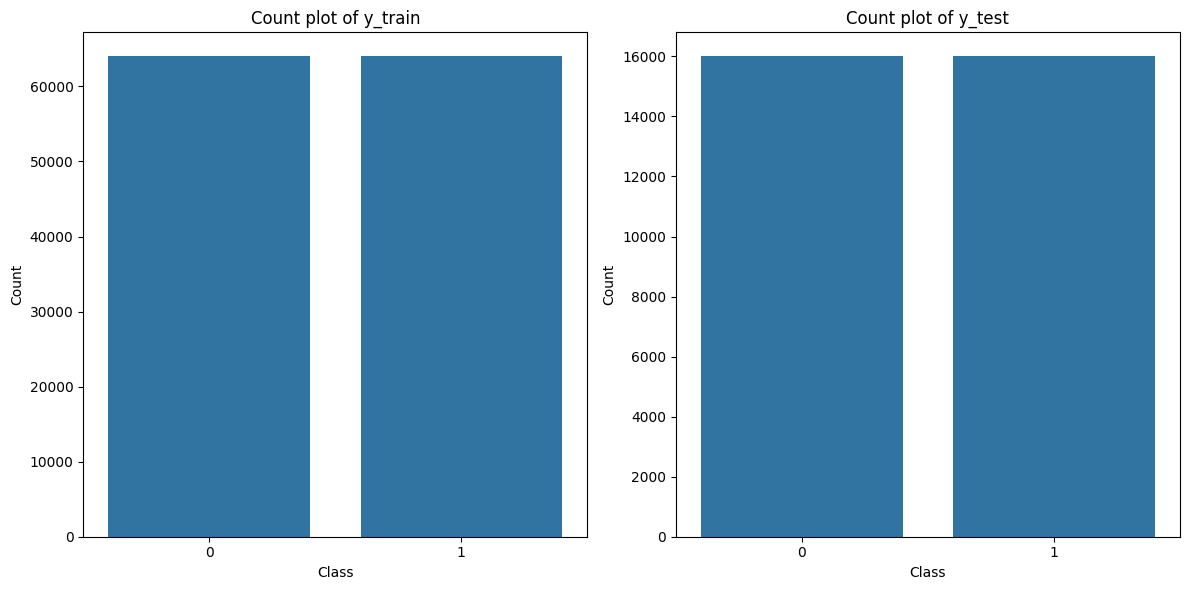

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for y_train
sns.countplot(x=y_train_lr, ax=axes[0])
axes[0].set_title('Count plot of y_train')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

# Plot for y_test
sns.countplot(x=y_test_lr, ax=axes[1])
axes[1].set_title('Count plot of y_test')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()

In [142]:
model = LogisticRegression()
model.fit(X_train_lr, y_train_lr)
y_pred_lr = model.predict(X_test_lr)
print(classification_report(y_test_lr, y_pred_lr))

              precision    recall  f1-score   support

           0       0.79      0.77      0.78     16002
           1       0.78      0.80      0.79     15998

    accuracy                           0.78     32000
   macro avg       0.78      0.78      0.78     32000
weighted avg       0.78      0.78      0.78     32000



In [143]:
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_data, y_data,
                                                    test_size = 0.1, random_state = 0)

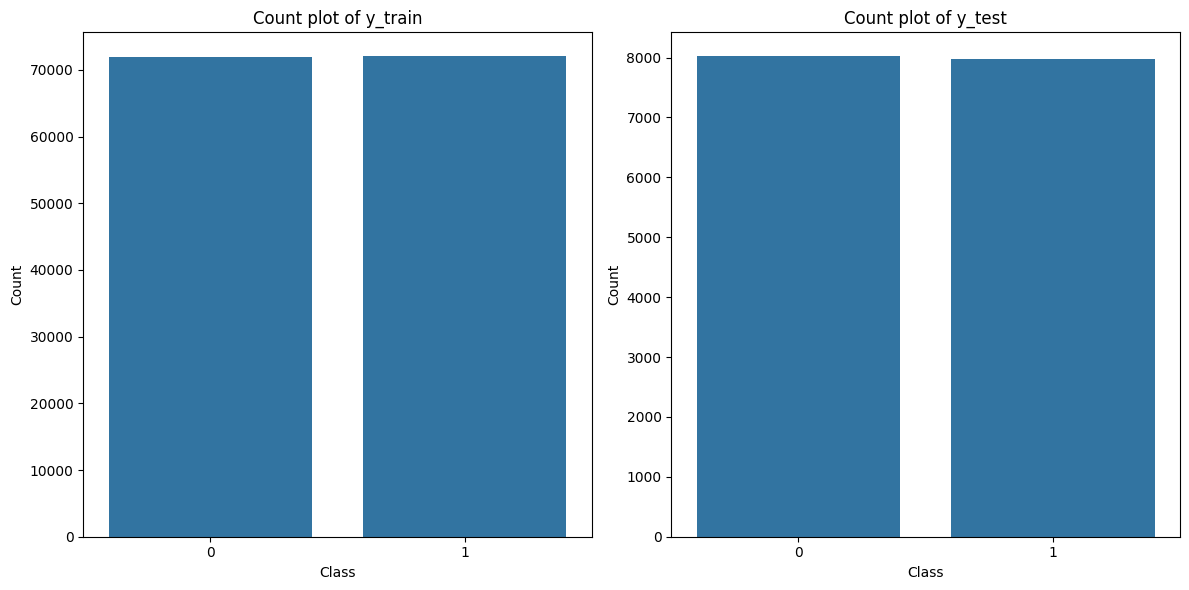

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for y_train
sns.countplot(x=y_train_lstm, ax=axes[0])
axes[0].set_title('Count plot of y_train')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

# Plot for y_test
sns.countplot(x=y_test_lstm, ax=axes[1])
axes[1].set_title('Count plot of y_test')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()

In [145]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train_lstm))

In [146]:
%%time

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 13275
CPU times: user 20 s, sys: 157 ms, total: 20.1 s
Wall time: 12.1 s


In [147]:
# Defining the model input length.
input_length = 60

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [148]:
vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)
tokenizer.word_index['love']

Tokenizer vocab length: 60000


48

In [151]:
X_train_sequences = tokenizer.texts_to_sequences(X_train_lstm)
X_test_sequences = tokenizer.texts_to_sequences(X_test_lstm)

print(X_train_lstm[10:15])
print(X_train_sequences[10:15])

[' heard auzzie was cnceled   news dsnt travel fast in canada lol  that sux but u ll be able 2 get    '
 'i must   stop   clock   watching   '
 'i am soo tired  my whole body hurts '
 ' i won a 2 month membership to curves so i am going to give that a try  '
 'customers love yelling at me ']
[[519, 16858, 28, 21013, 451, 11396, 1507, 641, 13, 1879, 50, 20, 2224, 21, 55, 975, 25, 468, 72, 37], [2, 308, 340, 1725, 135], [2, 15, 146, 167, 7, 414, 793, 356], [2, 633, 5, 72, 531, 7385, 3, 10961, 19, 2, 15, 34, 3, 303, 20, 5, 273], [3262, 48, 4327, 27, 18]]


In [152]:
X_train_lstm = pad_sequences(X_train_sequences, maxlen=input_length)
X_test_lstm  = pad_sequences(X_test_sequences , maxlen=input_length)

print("X_train.shape:", X_train_lstm.shape)
print("X_test.shape :", X_test_lstm.shape)
X_train_lstm[10], X_test_lstm[10]

X_train.shape: (144000, 60)
X_test.shape : (16000, 60)


(array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,   519, 16858,    28, 21013,   451,
        11396,  1507,   641,    13,  1879,    50,    20,  2224,    21,
           55,   975,    25,   468,    72,    37], dtype=int32),
 array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    40,  2958, 38910], dtype=int32))

In [153]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)
embedding_matrix[50]

Embedding Matrix Shape: (60000, 100)


array([ 0.13098112, -0.19444846,  0.65383863,  0.30257678,  0.07318929,
       -0.93554109,  0.20451692,  0.64517683, -0.3744565 , -1.09784997,
        0.16099381,  0.01559693,  0.24127211,  1.48724723,  0.60982072,
        0.38747928, -0.4659439 , -0.30891955,  0.18736558, -0.16805911,
        1.37163687,  0.30478698, -0.00493511, -0.53906459,  0.21609993,
       -0.46957737, -0.74015045, -0.53508806, -0.69554812, -0.51893723,
       -0.8007791 ,  0.38012239,  0.67093879, -0.28792936,  0.36760163,
       -0.70123959,  0.66583955, -0.01399574,  0.39892253, -0.10519548,
        0.31588122,  0.94633967,  0.13290603,  0.23830327, -0.53174877,
        1.07923424, -0.89517355,  1.27176976,  0.66740328,  0.77188468,
       -1.1274339 ,  1.06905687, -0.20197499,  0.30332726,  0.0394416 ,
       -0.13331652, -0.22761996,  0.45654553, -0.91199732, -0.17252837,
       -0.42560005,  0.45748162, -1.28595269,  0.03746971,  1.0003705 ,
        0.55051482, -0.8403762 ,  1.27372241, -0.50202143, -0.66

In [154]:
from keras import Sequential
from keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [155]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        LSTM(64, dropout=0.3, return_sequences=True),
        # Bidirectional(LSTM(64, dropout=0.3, return_sequences=True)),
        # Conv1D(64, 5, activation='relu'),
        GlobalMaxPool1D(),
        # Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model


In [156]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 60, 100)           6000000   
                                                                 
 lstm_4 (LSTM)               (None, 60, 64)            42240     
                                                                 
 global_max_pooling1d_4 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6042305 (23.05 MB)
Trainable params: 42305 (165.25 KB)
Non-trainable params: 6000000 (22.89 MB)
_________________________________________________________________


In [157]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [158]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/7
254/254 [==============================] - 80s 314ms/step - loss: 0.5552 - accuracy: 0.7135 - val_loss: 0.5035 - val_accuracy: 0.7538 - lr: 0.0010
Epoch 2/7
254/254 [==============================] - 67s 264ms/step - loss: 0.5097 - accuracy: 0.7488 - val_loss: 0.4853 - val_accuracy: 0.7624 - lr: 0.0010
Epoch 3/7
254/254 [==============================] - 65s 255ms/step - loss: 0.4957 - accuracy: 0.7590 - val_loss: 0.4798 - val_accuracy: 0.7647 - lr: 0.0010
Epoch 4/7
254/254 [==============================] - 64s 250ms/step - loss: 0.4855 - accuracy: 0.7639 - val_loss: 0.4702 - val_accuracy: 0.7742 - lr: 0.0010
Epoch 5/7
254/254 [==============================] - 63s 249ms/step - loss: 0.4782 - accuracy: 0.7692 - val_loss: 0.4648 - val_accuracy: 0.7757 - lr: 0.0010
Epoch 6/7
254/254 [==============================] - 66s 260ms/step - loss: 0.4711 - accuracy: 0.7724 - val_loss: 0.4606 - val_accuracy: 0.7793 - lr: 0.0010
Epoch 7/7
254/254 [==============================] - 65s 2

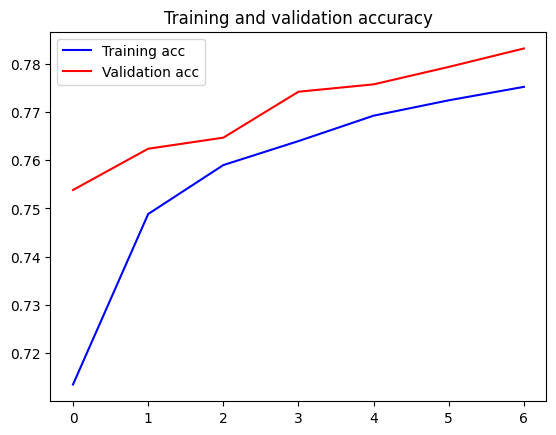

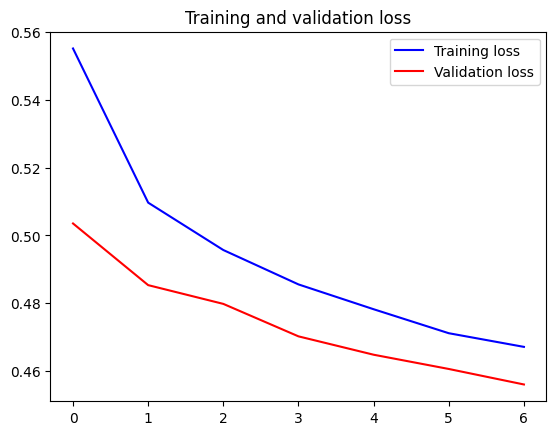

500/500 [==============================] - 6s 10ms/step
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      8021
           1       0.80      0.76      0.78      7979

    accuracy                           0.79     16000
   macro avg       0.79      0.79      0.78     16000
weighted avg       0.79      0.79      0.78     16000

CPU times: user 11min 52s, sys: 22.8 s, total: 12min 15s
Wall time: 8min 1s


In [160]:
%%time

history = training_model.fit(
    X_train_lstm, y_train_lstm,
    batch_size=512,
    epochs=7,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()



In [165]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

y_pred_lstm = training_model.predict(X_test_lstm)

# Converting prediction to reflect the sentiment predicted.
y_pred_lstm = np.where(y_pred_lstm>=0.5, 1, 0)

print(classification_report(y_test_lstm, y_pred_lstm))

500/500 [==============================] - 9s 18ms/step
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      8021
           1       0.80      0.76      0.78      7979

    accuracy                           0.79     16000
   macro avg       0.79      0.79      0.78     16000
weighted avg       0.79      0.79      0.78     16000



[[12325  3677]
 [ 3253 12745]]
[[6484 1537]
 [1902 6077]]


Text(0.5, 1.0, 'LSTM')

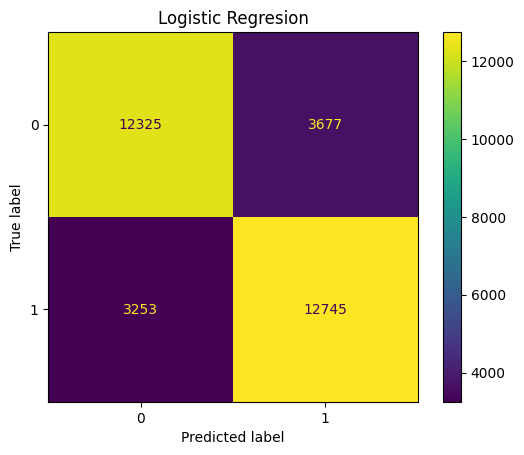

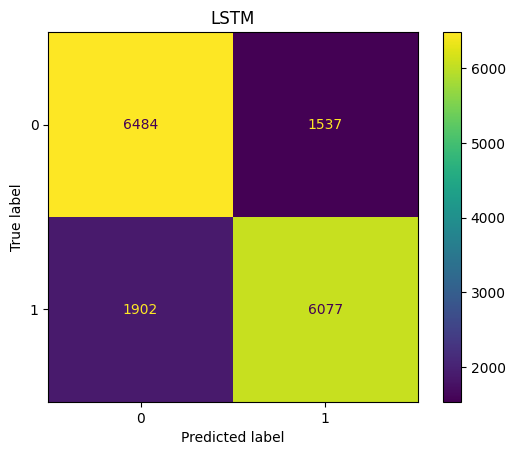

In [166]:
print(confusion_matrix(y_test_lr, y_pred_lr))
print(confusion_matrix(y_test_lstm, y_pred_lstm))
cm_gb = ConfusionMatrixDisplay(confusion_matrix(y_test_lr, y_pred_lr)).plot()
cm_gb.ax_.set_title('Logistic Regresion')
plt.grid(False)
cm_knn = ConfusionMatrixDisplay(confusion_matrix(y_test_lstm, y_pred_lstm)).plot()
cm_knn.ax_.set_title('LSTM')
# plt.grid(False)